In [4]:
# Setup - Clone repo da GitHub
!git clone https://github.com/Gabriele-mp/PhobiaShield.git
%cd PhobiaShield
!git checkout TheArchitect
!pip install -q -e .

Cloning into 'PhobiaShield'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 84 (delta 20), reused 75 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (84/84), 67.38 KiB | 6.13 MiB/s, done.
Resolving deltas: 100% (20/20), done.
/content/PhobiaShield/PhobiaShield
Branch 'TheArchitect' set up to track remote branch 'TheArchitect' from 'origin'.
Switched to a new branch 'TheArchitect'
  Preparing metadata (setup.py) ... done


In [5]:
# GPU Check
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f}GB")

Device: cuda
GPU: Tesla T4
Memory: 15.8GB


In [6]:
# Import PhobiaShield
import sys
sys.path.append('..')  # Add parent directory

from src.models.phobia_net import PhobiaNet
from src.models.loss import PhobiaLoss

In [15]:
# Metodo DEFINITIVO: carica config esistente
from omegaconf import OmegaConf

# Carica il config YAML già presente nella repo
model_cfg = OmegaConf.load('cfg/model/tiny_yolo.yaml')

# Initialize model
model = PhobiaNet(model_cfg).to(device)
loss_fn = PhobiaLoss(
    lambda_coord=5.0,
    lambda_obj=1.0,
    lambda_noobj=0.5,
    lambda_class=1.0,
    grid_size=13,
    num_boxes=2,
    num_classes=3
)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Parameters: 1,581,984


In [16]:
# Test Forward Pass
batch = torch.randn(4, 3, 416, 416).to(device)
output = model(batch)
print(f"Input: {batch.shape}")
print(f"Output: {output.shape}")
print(f"Expected: (4, 13, 13, 16)")

Input: torch.Size([4, 3, 416, 416])
Output: torch.Size([4, 13, 13, 16])
Expected: (4, 13, 13, 16)


In [17]:
# Test Loss
targets = torch.zeros(4, 13, 13, 16).to(device)
targets[0, 5, 5, 0:5] = torch.tensor([0.5, 0.5, 0.3, 0.3, 1.0])  # Box
targets[0, 5, 5, 10] = 1.0  # Class 0 (clown)

loss, metrics = loss_fn(output, targets)
print("\nLoss Components:")
for k, v in metrics.items():
    print(f"  {k}: {v}")


Loss Components:
  total_loss: 240.05963134765625
  coord_loss: 1.0613980293273926
  conf_loss_obj: 3.1316099166870117
  conf_loss_noobj: 461.56414794921875
  class_loss: 0.8389512896537781
  n_obj_cells: 1
  n_noobj_cells: 675


In [18]:
# Quick Training Test
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Training 5 iterations:")
for i in range(5):
    optimizer.zero_grad()
    output = model(batch)
    loss, metrics = loss_fn(output, targets)
    loss.backward()
    optimizer.step()
    print(f"  Iter {i+1}: Loss={metrics['total_loss']:.4f}")

print("\n✅ All tests passed!")

Training 5 iterations:
  Iter 1: Loss=240.0596
  Iter 2: Loss=2223.8215
  Iter 3: Loss=1184.9321
  Iter 4: Loss=1036.9121
  Iter 5: Loss=776.8698

✅ All tests passed!


Training 20 iterations con LR basso:
  Iter  5: Loss= 251.62 (Coord=1.16, Conf_obj=0.00, Conf_noobj=491.66)
  Iter 10: Loss= 140.34 (Coord=1.61, Conf_obj=0.00, Conf_noobj=264.61)
  Iter 15: Loss=  78.11 (Coord=0.97, Conf_obj=0.00, Conf_noobj=146.56)
  Iter 20: Loss=  44.38 (Coord=0.35, Conf_obj=0.00, Conf_noobj=85.27)


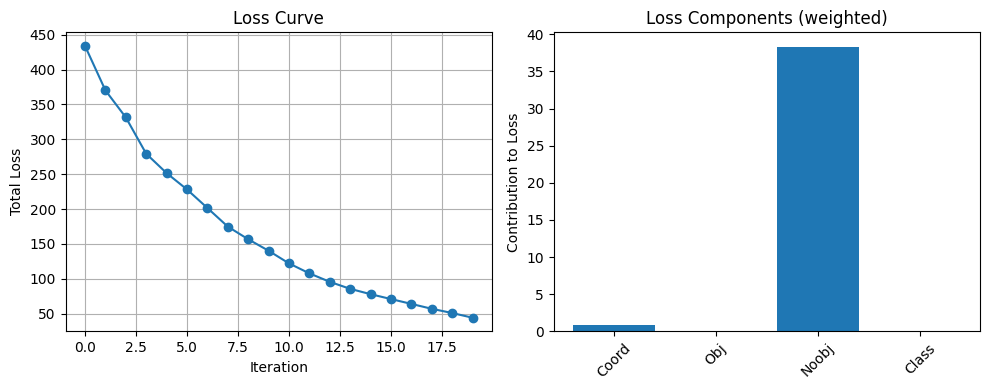


✅ Loss reduction: 433.8 → 44.4 (89.8% decrease)


In [20]:
# TEST MIGLIORE con LR basso e più iterations
import matplotlib.pyplot as plt

# Reset model
model = PhobiaNet(model_cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # LR 10× più basso!

# Crea batch con VERO pattern (non random)
torch.manual_seed(42)  # Seed per reproducibilità
batch = torch.randn(8, 3, 416, 416).to(device)  # Batch più grande

# Target con 2 oggetti (più realistico)
targets = torch.zeros(8, 13, 13, 16).to(device)
targets[0, 5, 5, :5] = torch.tensor([0.5, 0.5, 0.3, 0.3, 1.0])
targets[0, 5, 5, 10] = 1.0  # clown
targets[1, 7, 8, :5] = torch.tensor([0.6, 0.4, 0.2, 0.25, 1.0])
targets[1, 7, 8, 11] = 1.0  # shark

# Training loop con tracking
losses = []
print("Training 20 iterations con LR basso:")
for i in range(20):
    optimizer.zero_grad()
    output = model(batch)
    loss, metrics = loss_fn(output, targets)
    loss.backward()
    optimizer.step()
    
    losses.append(metrics['total_loss'])
    if (i+1) % 5 == 0:
        print(f"  Iter {i+1:2d}: Loss={metrics['total_loss']:7.2f} "
              f"(Coord={metrics['coord_loss']:.2f}, "
              f"Conf_obj={metrics['conf_loss_obj']:.2f}, "
              f"Conf_noobj={metrics['conf_loss_noobj']:.2f})")

# Plot loss curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Total Loss')
plt.title('Loss Curve')
plt.grid(True)

# Plot loss components
plt.subplot(1, 2, 2)
optimizer.zero_grad()
output = model(batch)
loss, metrics = loss_fn(output, targets)
components = {
    'Coord': metrics['coord_loss'] * 5.0,
    'Obj': metrics['conf_loss_obj'],
    'Noobj': metrics['conf_loss_noobj'] * 0.5,
    'Class': metrics['class_loss']
}
plt.bar(components.keys(), components.values())
plt.ylabel('Contribution to Loss')
plt.title('Loss Components (weighted)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n✅ Loss reduction: {losses[0]:.1f} → {losses[-1]:.1f} "
      f"({(losses[0]-losses[-1])/losses[0]*100:.1f}% decrease)")
